In [1]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2025-05-19 10:40:00.745244: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747651200.761854   11124 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747651200.766855   11124 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747651200.779774   11124 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747651200.779788   11124 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747651200.779790   11124 computation_placer.cc:177] computation placer alr

In [2]:
# Načítanie dát
df = pd.read_csv("toxic_training.csv")
df = df.dropna()

# Prevod labelov na celé čísla
df['label'] = df['label'].astype(int)

In [3]:
# Rozdelenie na trénovacie/testovacie dáta
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

In [4]:
# Načítanie predtrénovaného SlovakBERT tokenizéra
tokenizer = RobertaTokenizer.from_pretrained('gerulata/slovakbert')

# Tokenizácia trénovacích a testovacích textov
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)

In [5]:
# Príprava TensorDatasetov
train_dataset = TensorDataset(
    torch.tensor(train_encodings['input_ids']),
    torch.tensor(train_encodings['attention_mask']),
    torch.tensor(train_labels.tolist(), dtype=torch.long)
)

test_dataset = TensorDataset(
    torch.tensor(test_encodings['input_ids']),
    torch.tensor(test_encodings['attention_mask']),
    torch.tensor(test_labels.tolist(), dtype=torch.long)
)

In [6]:
# Inicializácia modelu SlovakBERT pre klasifikáciu do 4 tried
model = RobertaForSequenceClassification.from_pretrained('gerulata/slovakbert', num_labels=4)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at gerulata/slovakbert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# Automatická detekcia zariadenia (GPU alebo CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)  # presunieme model na príslušné zariadenie

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50264, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [8]:
# Rozdelenie dát do batchov (skupín)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
# Výber optimalizátora
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [10]:
# Loss funkcia pre viactriednu klasifikáciu
loss_fn = torch.nn.CrossEntropyLoss()

In [11]:
# Hlavný tréningový cyklus pre model, beží 10 epôch
for epoch in range(10):
    model.train()
    total_loss = 0
    
    # Iterácia cez jednotlivé batch-e z trénovacieho DataLoaderu
    for batch in train_loader:
        optimizer.zero_grad() # # Odstránenie starých gradientov, aby sa neprekrývali s novými

        # Prenesieme dáta na GPU alebo CPU podľa konfigurácie
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        # Model vypočíta predikcie
        outputs = model(input_ids, attention_mask=attention_mask)

        # Vypočítanie straty medzi predikciou a skutočnými štítkami
        loss = loss_fn(outputs.logits, labels)
        
        # Výpočet gradientov podľa straty
        loss.backward()

        # Aktualizacia váhy modelu podľa gradientov
        optimizer.step()

        # Strata k celkovej strate pre túto epochu
        total_loss += loss.item()

    # Priemerná strata na konci epóchy
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 1.2175
Epoch 2, Loss: 0.7926
Epoch 3, Loss: 0.4850
Epoch 4, Loss: 0.3393
Epoch 5, Loss: 0.1963
Epoch 6, Loss: 0.1139
Epoch 7, Loss: 0.1703
Epoch 8, Loss: 0.1634
Epoch 9, Loss: 0.0517
Epoch 10, Loss: 0.0503


In [12]:
# Prepnutie modelu do režimu vyhodnotenia
model.eval()

# Premenné na uloženie predikcií a skutočných hodnôt pre neskoršie porovnanie
all_preds = []   # Predikcie modelu
all_labels = []  # Reálne (skutočné) štítky z datasetu

In [13]:
# Zobrazenie všetkých časti testovacích dát
for batch in test_loader:
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].cpu().numpy() # Získanie skutočných odpovedí (štítkov), ktoré model porovnáva so svojimi predikciami

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask) #  Model predpovedá výstupy pre dané vstupy
    
    # Výber triedy, ktorú model odhadol ako najpravdepodobnejšiu
    preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()


    # Uloženie predikcie a skutočných odpovedí na porovnanie
    all_preds.extend(preds)
    all_labels.extend(labels)

In [14]:
# Vypočítanie úspešnosťi modelu
accuracy = accuracy_score(all_labels, all_preds)
print("Úspešnosť modelu:", accuracy)

Úspešnosť modelu: 0.8478964401294499


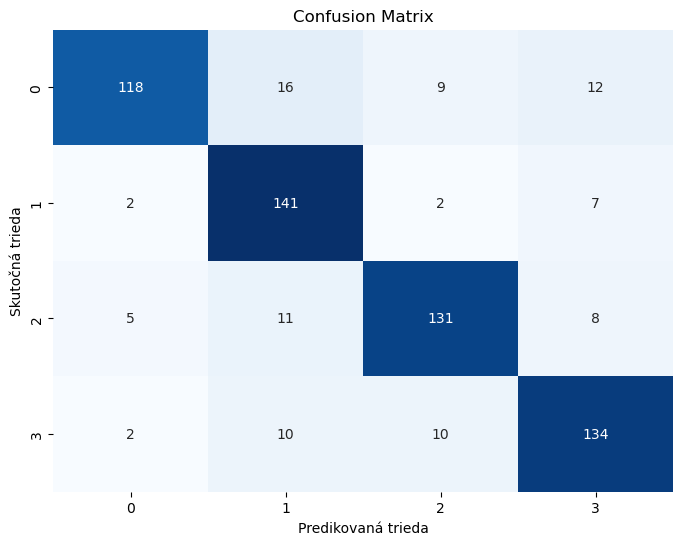

In [15]:
# Vytváranie matrice zámen
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predikovaná trieda')
plt.ylabel('Skutočná trieda')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# Výpočet falošnej negatívnej miery
def false_negative_rate(fn, tp):
    return fn / (fn + tp) if (fn + tp) > 0 else 0.0

total_fn = 0
total_tp = 0

for i in range(4):  # pre všetky 4 triedy
    fn = sum(cm[i, :]) - cm[i, i]  
    tp = cm[i, i]  
    total_fn += fn
    total_tp += tp

print("False negatives:", total_fn)
print("True positives:", total_tp)

overall_fnr = false_negative_rate(total_fn, total_tp)
print(f"False negative rate: {overall_fnr:.4f}")

False negatives: 94
True positives: 524
False negative rate: 0.1521
